In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
data = pd.read_csv("/content/drive/MyDrive/Data Science/customer_support_tickets.csv")
print(data.info())
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8469 entries, 0 to 8468
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Ticket ID                     8469 non-null   int64  
 1   Customer Name                 8469 non-null   object 
 2   Customer Email                8469 non-null   object 
 3   Customer Age                  8469 non-null   int64  
 4   Customer Gender               8469 non-null   object 
 5   Product Purchased             8469 non-null   object 
 6   Date of Purchase              8469 non-null   object 
 7   Ticket Type                   8469 non-null   object 
 8   Ticket Subject                8469 non-null   object 
 9   Ticket Description            8469 non-null   object 
 10  Ticket Status                 8469 non-null   object 
 11  Resolution                    2769 non-null   object 
 12  Ticket Priority               8469 non-null   object 
 13  Tic

In [2]:
# Convert dates
data['Date of Purchase'] = pd.to_datetime(data['Date of Purchase'], errors='coerce')
data['First Response Time'] = pd.to_datetime(data['First Response Time'], errors='coerce')
data['Time to Resolution'] = pd.to_datetime(data['Time to Resolution'], errors='coerce')

# Replace inf and drop NAs
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.dropna(subset=['Customer Satisfaction Rating'], inplace=True)

# Encode categorical variables
from sklearn.preprocessing import LabelEncoder

categorical_cols = ['Customer Gender', 'Product Purchased', 'Ticket Type', 'Ticket Subject',
                    'Ticket Status', 'Ticket Priority', 'Ticket Channel']

for col in categorical_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])

# Fill missing numeric features with median
data['Customer Age'] = data['Customer Age'].fillna(data['Customer Age'].median())

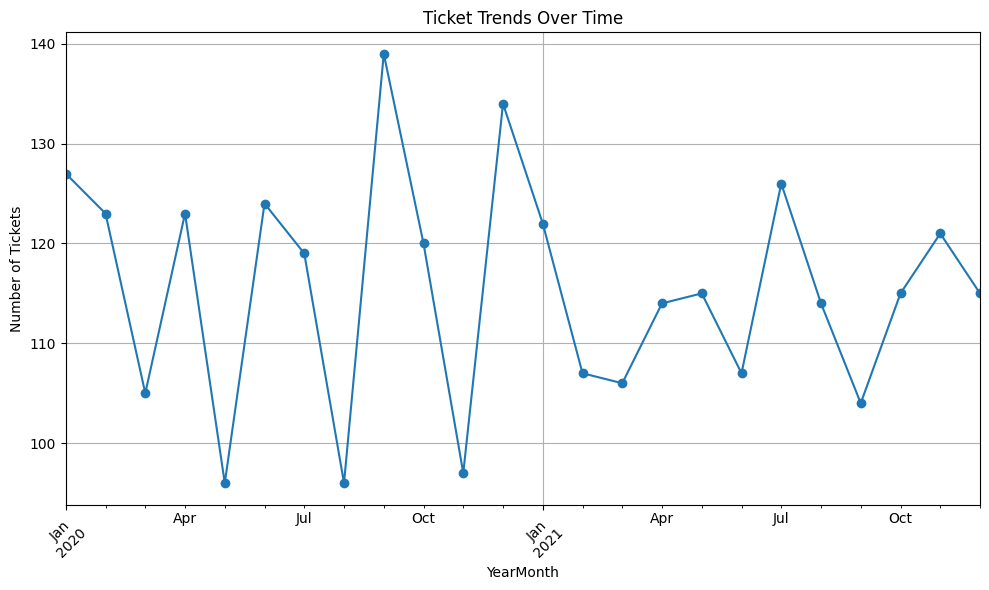

In [3]:
data['YearMonth'] = data['Date of Purchase'].dt.to_period('M')
ticket_trends = data.groupby('YearMonth').size()

plt.figure(figsize=(10, 6))
ticket_trends.plot(kind='line', marker='o')
plt.title('Ticket Trends Over Time')
plt.ylabel('Number of Tickets')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

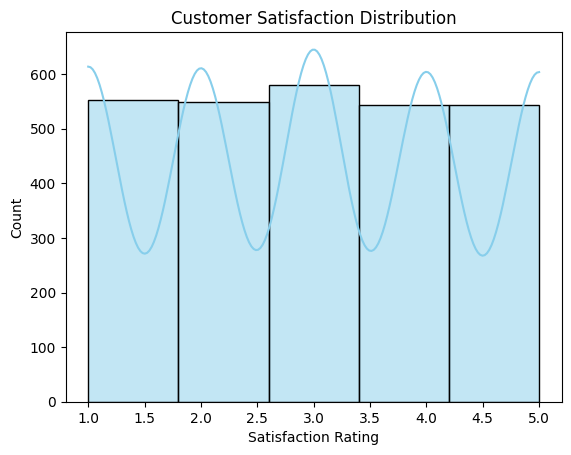

In [4]:
sns.histplot(data['Customer Satisfaction Rating'], bins=5, kde=True, color='skyblue')
plt.title('Customer Satisfaction Distribution')
plt.xlabel('Satisfaction Rating')
plt.show()

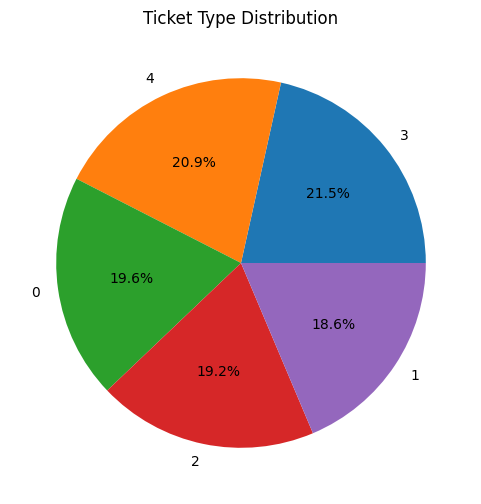

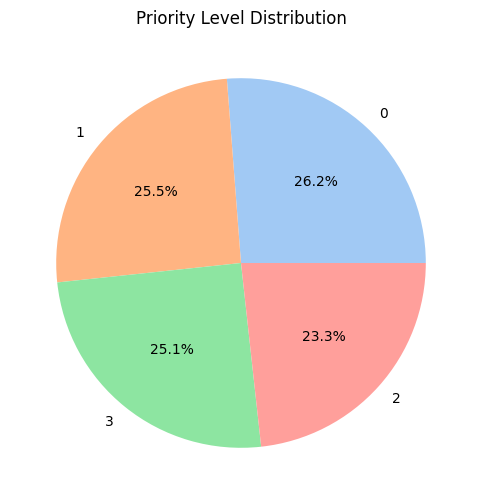

In [5]:
plt.figure(figsize=(6, 6))
data['Ticket Type'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Ticket Type Distribution')
plt.ylabel('')
plt.show()

plt.figure(figsize=(6, 6))
data['Ticket Priority'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=sns.color_palette("pastel"))
plt.title('Priority Level Distribution')
plt.ylabel('')
plt.show()

/tmp/ipython-input-6-2985040644.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tickets_by_age = data.groupby('Age Group').size()


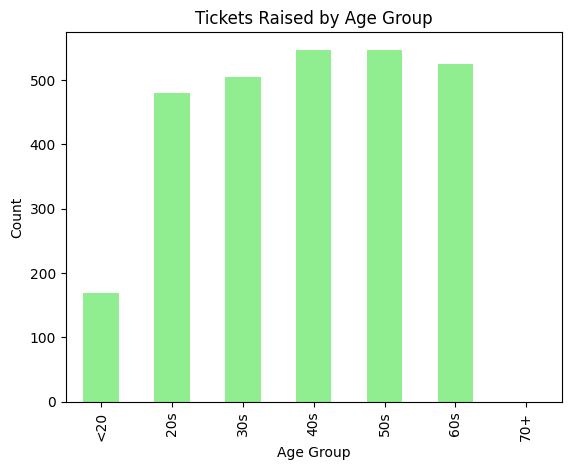

In [6]:
# By Age Group
bins = [0, 20, 30, 40, 50, 60, 70, 80]
labels = ['<20', '20s', '30s', '40s', '50s', '60s', '70+']
data['Age Group'] = pd.cut(data['Customer Age'], bins=bins, labels=labels)

tickets_by_age = data.groupby('Age Group').size()

tickets_by_age.plot(kind='bar', color='lightgreen')
plt.title('Tickets Raised by Age Group')
plt.ylabel('Count')
plt.show()

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

# Features & Target
X = data[['Customer Age', 'Customer Gender', 'Product Purchased', 'Ticket Type',
          'Ticket Status', 'Ticket Priority', 'Ticket Channel']]
y = data['Customer Satisfaction Rating'].astype(int)

# Split & Scale
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

In [8]:
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy Score: 0.19855595667870035

Classification Report:
               precision    recall  f1-score   support

           1       0.17      0.17      0.17       168
           2       0.17      0.17      0.17       174
           3       0.24      0.25      0.25       175
           4       0.21      0.20      0.20       162
           5       0.20      0.21      0.20       152

    accuracy                           0.20       831
   macro avg       0.20      0.20      0.20       831
weighted avg       0.20      0.20      0.20       831


Confusion Matrix:
 [[28 38 33 31 38]
 [38 29 48 31 28]
 [35 33 44 32 31]
 [37 34 27 32 32]
 [28 34 31 27 32]]


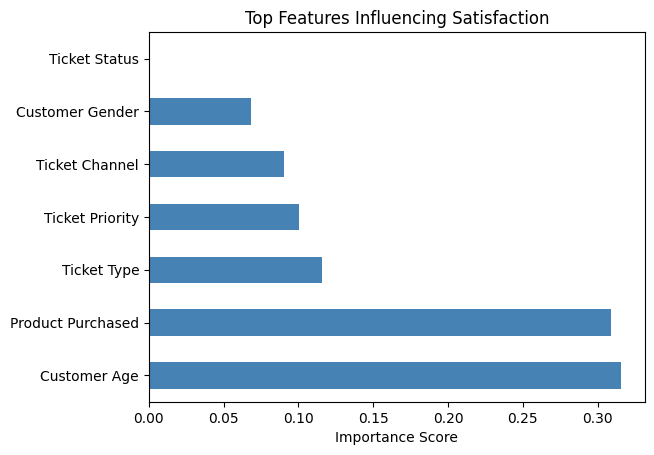

In [9]:
feature_importances = pd.Series(model.feature_importances_, index=X.columns)
feature_importances.nlargest(7).plot(kind='barh', color='steelblue')
plt.title("Top Features Influencing Satisfaction")
plt.xlabel("Importance Score")
plt.show()